# Project 2 Draft 7

11/1/2018

In [53]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Make System Function

In [77]:
init = State(S1=19.2e6, S2=14.4e6, I1=4.8e6, I2=1.6e6, M=0.8)

"""
S1 = number of uninfected individuals with AA genotype
S2 = number of uninfected individuals with AS genotype
I1 = number of infected individuals with AA genotype
I2 = number of infected individuals with AS genotype
M = Proportion of mosquitoes with plasmodium parasite
"""
system = System(t0=0, t_end=200, dt = 1,
                  a = 1, #Biting rate per human per mosquito.
                  #aa = aa, #Proportion decrease in biting rate w/ mosquito nets
                  Nh = 40000000, #=S1 + S2 + I1 + I2 ; Total human population
                  θ1 = 0.05, #Probability that an individual acquires plasmodium per bite type AA
                  #θ1a = θ1a, #Proportion decrease in probability of acquiring plasmodium 
                  θ2 = 0.06, #Probability that an individual acquires plasmodium per bite type AS
                  #θ2a = θ2a, #Proportion decarease in probability of acquiring plasmodium
                  φ1 = 0.05, #Probability that a mosquito acquires plasmodium from biting an infected individual type AA
                  φ2 = 0.09, #Probability that a mosquito acquires plasmodium from biting an infected individual type AS
                  λh1 = 10e6, # = aθ1(Im/Nh), Im = 1e15 x 0.8
                  λh2 = 1.2e6, # = aθ2(Im/Nh), Im = 1e15 x 0.8
                  λm1 = 0.08, # = aφ1(I1+I2 +εR)/Nh
                  λm2 = 0.144, # = aφ1(I1+I2 +εR)/Nh
                  δm = 0.07, #Mortality rate of mosquitoes
                  c = 4, #Ratio of mosquitoes to human.
                  μ1 = 0.00003, #Human natural mortality rate
                  μ2 = 0.00005, #Human natural mortality rate + mortality rate due to sickle cell complications
                  ν = 0.00002, #Extra mortality due to sickle cell gene complications
                  α1 = 0.0001, #Malaria-induced mortality rate for genotype AA
                  α2 = 0.00005, #Malaria-induced mortality rate for genotype AS
                  #q = q, Frequency of the S-gene
                  γ1 = 0.05, #Recovery rate from malaria for genotype AA
                  γ2 = 0.09, #Recovery rate from malaria for genotype AS
                  bNh = 0.033, #Per capita birth rate of humans b(1 − Nh/K), b = 0.00004, K = 10000 (per year)
                  w = 0.4, #Fraction of AS individuals w- 0.1, w = 0.7, which one to use? w = 0.4
                  P1 = 0.64, #Fraction of the total birth of individuals of genotype AA = 0.64
                  P2 = 0.32) #Fraction of the total birth of individuals of genotype AS = 0.32

,values
t0,0.000000e+00
t_end,2.000000e+02
dt,1.000000e+00
a,1.000000e+00
Nh,4.000000e+07
θ1,5.000000e-02
θ2,6.000000e-02
φ1,5.000000e-02
φ2,9.000000e-02
λh1,1.000000e+07


### Plot Results

In [94]:
def plot_results(results):
    """Plot the results of a RLEV model.
    """
    
    #plot(S1, '--', label='Succeptible 1')
    #plot(S2, '-', label='Succeptible 2')
    plot(results.I1, '', label='AA Genotype')
    plot(results.I2, '', label='AS Genotype')
    #plot(M, ':', label='Proportion of Mosquitos Infected')
    decorate(xlabel='Time (days)',
             ylabel='Population')

### Update Function

In [91]:
def update_func(state, t, system):
    s1, s2, i1, i2, m = state
    #unpack(system)
    #functions from paper
    Nh = s1 + s2 + i1 + i2
    I_tot = i1 + i2
    λh1 = a*θ1*(m/Nh)
    λh2 = a*θ2*(m/Nh)
    λm1 = a*φ1*(I_tot/Nh)
    λm2 = a*φ2*(I_tot/Nh) #a*φ2*((I_tot + (ε * R))/Nh)
    #bNh = b*(1 − Nh/K) # is this (1-Nh)/K or 1 - (Nh/K)??
    
    dS1_dt = (P1*bNh*Nh - μ1*s1 - λh1*s1 + γ1*i1)*dt
    dS2_dt = (P2*bNh*Nh - μ2*s2 - λh2*s2 + γ2*i2)*dt
    dI1_dt = (λh1*s1 - (μ1 + γ1 + α1)*i1)*dt
    dI2_dt = (λh2*s2 - (μ2 + γ2 + α2)*i2)*dt
    dm_dt  = ((1 - m) * (λm1 + λm2) - δm)*dt
    
    s1 += dS1_dt
    s2 += dS2_dt
    i1 += dI1_dt
    i2 += dI2_dt
    m  += dm_dt 
    
    return State(S1=s1, S2=s2, I1=i1, I2=i2, M=m)

### Run Simulation Function 

In [92]:
def run_simulation(system, update_func):
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[t0] = init
    
    for t in linrange(t0, t_end/dt):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

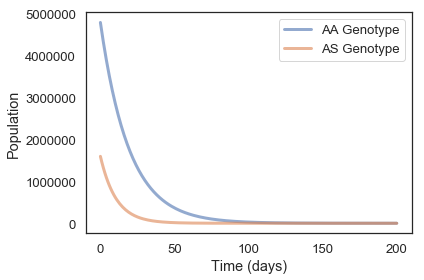

In [95]:
results = run_simulation(system, update_func)
plot_results(results)

# results.I1.plot()
# results.I2.plot()
# decorate(xlabel='Time (days)',
#         ylabel='Number of Infected People')

#plot_results(results)

http://scholar.sun.ac.za/handle/10019.1/17989 (source of equations-you can download the full text by searching the web for "Modelling Malaria and Sickle Cell Gene. by Juliet Nakakawa Thesis" and it is currently the first result)

https://www.nejm.org/doi/full/10.1056/NEJMoa1515257 (source of efficacy of Malaria Vaccine)
